In this discussion notebook we will discuss on ensambles and boosting. For the discussion, we will use decision trees.

In [18]:
# Import all required libraries
from __future__ import division # For python 2.*

import numpy as np
import matplotlib.pyplot as plt
import mltools as ml

np.random.seed(0)
%matplotlib inline

## Bagging and Random Forests
Bagging is a simple idea that the average prediction over multiple classifiers is better than any single classifier. Each classifier is trained on a random sample of the data (bootstrapping).

### Loading the data

In [19]:
X = np.genfromtxt("data/X_train.txt",delimiter=None)
Y = np.genfromtxt("data/Y_train.txt",delimiter=None)
[Xtr,Xva,Ytr,Yva] = ml.splitData(X,Y,0.80)

Xte = np.genfromtxt('data/X_test.txt',delimiter=None)
Xt, Yt = Xtr[:4000], Ytr[:4000]

In [20]:
Xt.shape

(4000, 14)

## Single Decision Tree
As a reminder, this is how we create a decision tree classifier with the mltools package.

You could set how many features you want to apply in the decision tree, using the argument nFeatures.

In [21]:
tree_one = ml.dtree.treeClassify(Xt, Yt, minParent=2**6, maxDepth=25, nFeatures=14)  # nFreatures would be randomly selected
probs = tree_one.predictSoft(Xte)

print("{0:>15}: {1:.4f}".format('Train AUC', tree_one.auc(Xt, Yt)))
print("{0:>15}: {1:.4f}".format('Validation AUC', tree_one.auc(Xva, Yva)))

      Train AUC: 0.8441
 Validation AUC: 0.6111


## Random Forest
We'll create a set of 10 random trees, each with bootstrapping, and combine them into a random forest.

In [22]:
np.random.seed(0)  # Resetting the seed in case you ran other stuff.
n_bags = 10
bags = []   # self.learners
for l in range(n_bags):
    # Each boosted data is the size of the original data. 
    Xi, Yi = ml.bootstrapData(Xt, Yt, Xt.shape[0])

    # Train the model on that draw
    tree = ml.dtree.treeClassify(Xi, Yi, minParent=2**6,maxDepth=25, nFeatures=6)
    bags.append(tree)

Printing the train and validation auc for all classifiers.

In [23]:
for l in range(n_bags):
    print(l)
    print("{0:>15}: {1:.4f}".format('Train AUC', bags[l].auc(Xt, Yt)))
    print("{0:>15}: {1:.4f}".format('Validation AUC', bags[l].auc(Xva, Yva)))

0
      Train AUC: 0.7615
 Validation AUC: 0.5942
1
      Train AUC: 0.7598
 Validation AUC: 0.5888
2
      Train AUC: 0.7509
 Validation AUC: 0.5975
3
      Train AUC: 0.7481
 Validation AUC: 0.6019
4
      Train AUC: 0.7480
 Validation AUC: 0.5997
5
      Train AUC: 0.7444
 Validation AUC: 0.5884
6
      Train AUC: 0.7521
 Validation AUC: 0.5906
7
      Train AUC: 0.7590
 Validation AUC: 0.5882
8
      Train AUC: 0.7523
 Validation AUC: 0.6059
9
      Train AUC: 0.7496
 Validation AUC: 0.5876


## Creating a BaggedTree class

In [24]:
class BaggedTree(ml.base.classifier):
    def __init__(self, learners):
        """Constructs a BaggedTree class with a set of learners. """
        self.learners = learners
    
    def predictSoft(self, X):
        """Predicts the probabilities with each bagged learner and average over the results. """
        n_bags = len(self.learners)
        preds = [self.learners[l].predictSoft(X) for l in range(n_bags)]
        return np.mean(preds, axis=0)

Note that this class doesn't have a train function. We assume the training was already done and we are getting the learners. As an excersice, try and write the train function yourself.

In [25]:
bt = BaggedTree(bags)
bt.classes = np.unique(Y)

print("{0:>15}: {1:.4f}".format('Train AUC', bt.auc(Xt, Yt)))
print("{0:>15}: {1:.4f}".format('Validation AUC', bt.auc(Xva, Yva)))

      Train AUC: 0.8922
 Validation AUC: 0.6524


Not surprisingly, the validation AUC has improved :)

# Gradient Boosted Trees
Boosting is kind of the opposite of bagging. In Bagging we have a set of really smart classifiers that we are afraid will overfit the data so we take the average of them to increase the prediction accuracy.

In boosting it's the other way around. We take a bunch of really "stupid" classifier and make them more complex by learning in a sequence where each time we learn from the previous classifier mistakes. 

With the decision trees example, in the bagging we took really smart random classifiers. In the boosting we are going to take one level trees.

### Loading the data
This is a regression problem so let's use a regression data :)

In [26]:
path_to_file = './data/poly_data.txt' 
data = np.genfromtxt(path_to_file, delimiter='\t') # Read data from file

X, Y = np.atleast_2d(data[:, 0]).T, data[:, 1]
X, Y = ml.shuffleData(X, Y)
Xtr, Xte, Ytr, Yte = ml.splitData(X, Y, 0.75)

/var/folders/k7/zcjp1w9x3xb16x_hqdfhxxrr0000gn/T/ipykernel_6180/3412089409.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=25)
/var/folders/k7/zcjp1w9x3xb16x_hqdfhxxrr0000gn/T/ipykernel_6180/3412089409.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=25)


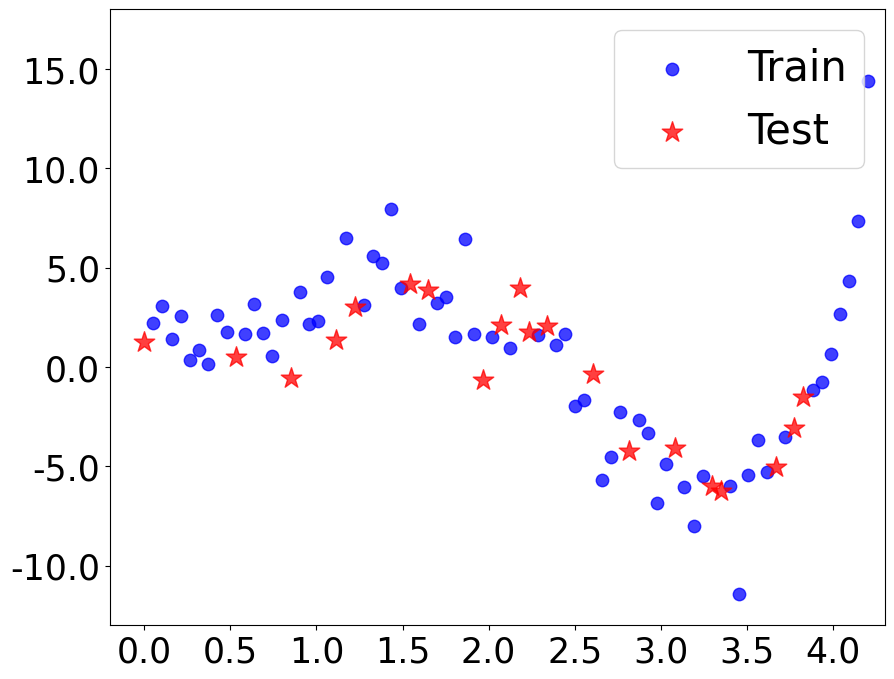

In [27]:
# Plotting the data
f, ax = plt.subplots(1, 1, figsize=(10, 8))
    
ax.scatter(Xtr, Ytr, s=80, color='blue', alpha=0.75, label='Train')
ax.scatter(Xte, Yte, s=240, marker='*', color='red', alpha=0.75, label='Test')

ax.set_xlim(-0.2, 4.3)
ax.set_ylim(-13, 18)
ax.set_xticklabels(ax.get_xticks(), fontsize=25)
ax.set_yticklabels(ax.get_yticks(), fontsize=25)   

# Controlling the size of the legend and the location.
ax.legend(fontsize=30, loc=0)

plt.show()

In [28]:
boosts = []
n_boosts = 100

Ytr_ = np.copy(Ytr)  # We're going to copy the data becuase each booster iteration we're going to mess with it.

for i in range(n_boosts):
    tree = ml.dtree.treeRegress(Xtr, Ytr_, maxDepth=1)
    boosts.append(tree)
    
    # Now "learning" from out mistakes.
    Ytr_ -= tree.predict(Xtr) 

Just for the fun of it, let's see what a single tree will do.

In [29]:
xs = np.linspace(0, 4.2, 200)
xs = np.atleast_2d(xs).T

ys = boosts[0].predict(xs)

/var/folders/k7/zcjp1w9x3xb16x_hqdfhxxrr0000gn/T/ipykernel_6180/63049748.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=25)
/var/folders/k7/zcjp1w9x3xb16x_hqdfhxxrr0000gn/T/ipykernel_6180/63049748.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=25)


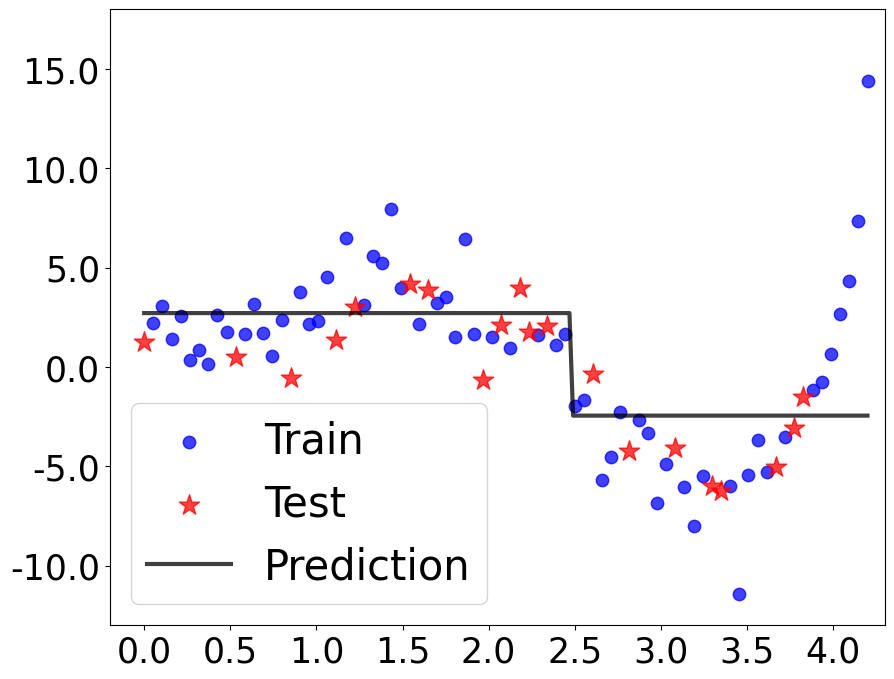

In [30]:
# Plotting the data
f, ax = plt.subplots(1, 1, figsize=(10, 8))
    
ax.scatter(Xtr, Ytr, s=80, color='blue', alpha=0.75, label='Train')
ax.scatter(Xte, Yte, s=240, marker='*', color='red', alpha=0.75, label='Test')

ax.plot(xs, ys, lw=3, color='black', alpha=0.75, label='Prediction')

ax.set_xlim(-0.2, 4.3)
ax.set_ylim(-13, 18)
ax.set_xticklabels(ax.get_xticks(), fontsize=25)
ax.set_yticklabels(ax.get_yticks(), fontsize=25)   

# Controlling the size of the legend and the location.
ax.legend(fontsize=30, loc=0)

plt.show()

In [31]:
print(boosts[0])

  if x[0] < 2.472150:
    Predict 2.7108037142857144
  else:
    Predict -2.4489228



Now let's predict using all the boosting we have

In [32]:
def predict(X, boosts):
    """Predicts regression values using boosting. """
    preds = [boosts[i].predict(X) for i in range(len(boosts))]
    
    # Notice that in the bagging we returning the mean, here we return the sum
    return np.sum(preds, axis=0)

In [33]:
xs = np.linspace(0, 4.2, 200)
xs = np.atleast_2d(xs).T

ys = predict(xs, boosts)

/var/folders/k7/zcjp1w9x3xb16x_hqdfhxxrr0000gn/T/ipykernel_6180/63049748.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=25)
/var/folders/k7/zcjp1w9x3xb16x_hqdfhxxrr0000gn/T/ipykernel_6180/63049748.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=25)


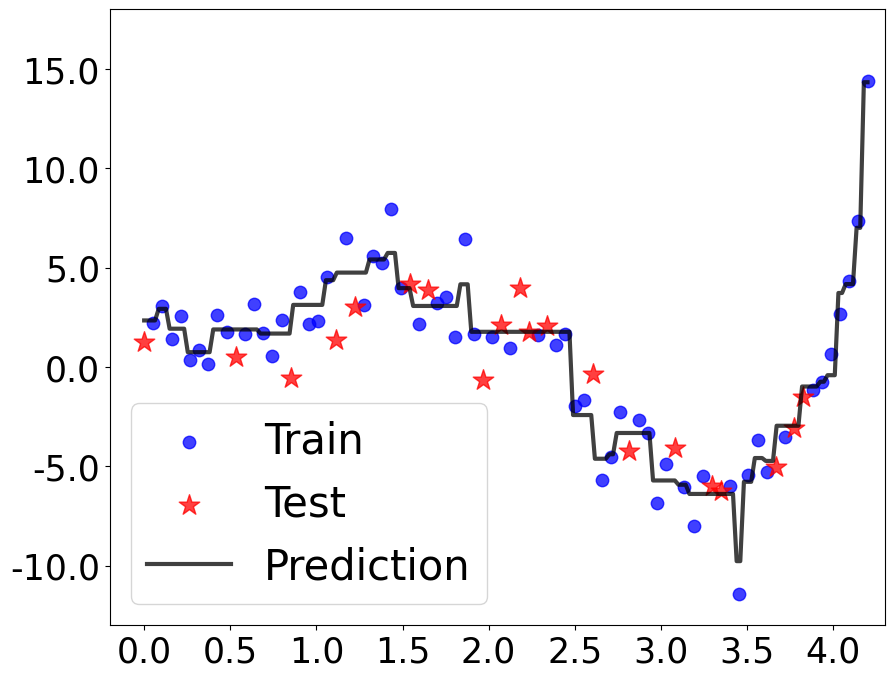

In [34]:
# Plotting the data
f, ax = plt.subplots(1, 1, figsize=(10, 8))
    
ax.scatter(Xtr, Ytr, s=80, color='blue', alpha=0.75, label='Train')
ax.scatter(Xte, Yte, s=240, marker='*', color='red', alpha=0.75, label='Test')

ax.plot(xs, ys, lw=3, color='black', alpha=0.75, label='Prediction')

ax.set_xlim(-0.2, 4.3)
ax.set_ylim(-13, 18)
ax.set_xticklabels(ax.get_xticks(), fontsize=25)
ax.set_yticklabels(ax.get_yticks(), fontsize=25)   

# Controlling the size of the legend and the location.
ax.legend(fontsize=30, loc=0)

plt.show()